In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [2]:
data = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test_data = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
head = data.head()

In [3]:
# data.describe()


In [4]:
# data.isnull().sum()

In [5]:
corr_mat = data.corr()
# print(corr_mat)

/tmp/ipykernel_20/2609469596.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = data.corr()


/tmp/ipykernel_20/4239501841.py:4: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_with_target = data.corrwith(data['Class']).sort_values(ascending=False)


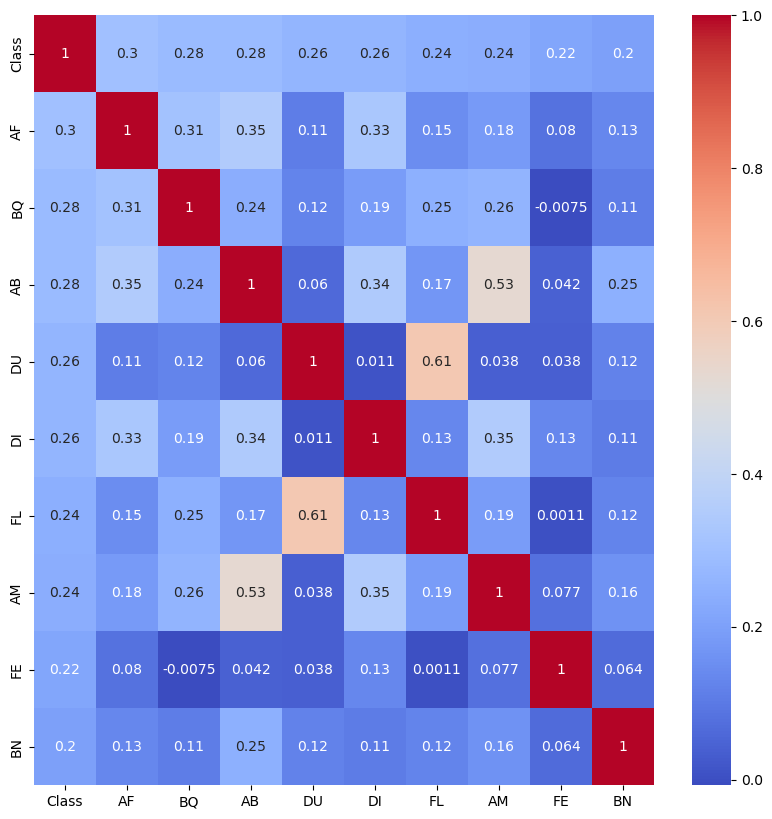

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_with_target = data.corrwith(data['Class']).sort_values(ascending=False)

top_corr_features = corr_with_target.head(10).index

plt.figure(figsize=(10,10))
sns.heatmap(data[top_corr_features].corr(), annot=True, cmap='coolwarm')
plt.show()


/tmp/ipykernel_20/2501600723.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()
/tmp/ipykernel_20/2501600723.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


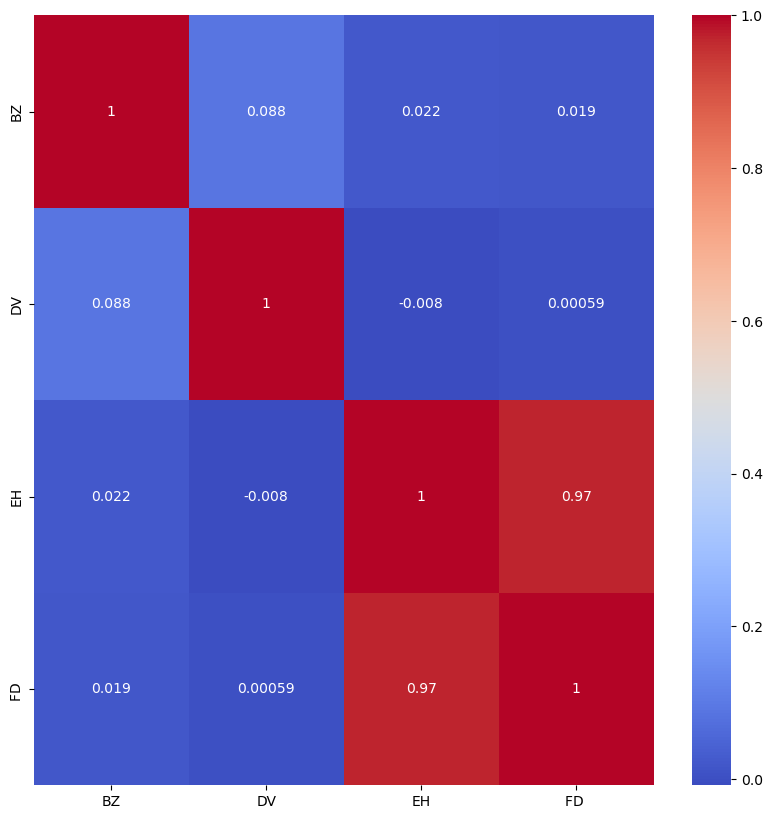

In [7]:
import numpy as np

# Start with the full correlation matrix
corr_matrix = data.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than a threshold (e.g., 0.8 or -0.8)
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.8)]

# Plot a heatmap for the highly correlated features
plt.figure(figsize=(10,10))
sns.heatmap(data[to_drop].corr(), annot=True, cmap='coolwarm')
plt.show()


In [8]:
from sklearn.model_selection import train_test_split
X = data.drop('Class', axis=1)
y = data['Class']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Preprocess data by replacing null values with mean

In [10]:
train_means = X_train.mean()
test_means = X_test.mean()

/tmp/ipykernel_20/1148867319.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_means = X_train.mean()
/tmp/ipykernel_20/1148867319.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_means = X_test.mean()


In [11]:
for feature in X_train.select_dtypes(include=[np.number]):
    X_train[feature].fillna(train_means[feature], inplace=True)
    X_test[feature].fillna(test_means[feature], inplace=True)
# data.isnull().sum()



Ensure nulls are gone

In [12]:
# print(X_train[X_train.isnull().any(axis=1)])
# print(X_train)

In [13]:

# X_train_dummy = pd.get_dummies(X_train['EJ'], prefix='EJ')

# # Concatenate the dummy DataFrame to the original DataFrame
# X_train = pd.concat([X_train, X_train_dummy], axis=1)

# X_train = X_train.drop('EJ', axis=1)

def dropEJ(data):
    dummy_data = pd.get_dummies(data['EJ'], prefix='EJ')
    data = pd.concat([data, dummy_data], axis=1)
    data = data.drop('EJ', axis=1)
    return data

X_train = dropEJ(X_train)
X_test = dropEJ(X_test)

In [14]:
X_train = X_train.drop(['Id'], axis=1)
X_test = X_test.drop(['Id'], axis=1)
print(X_test.isnull().any().any())
nulls = X_test.isnull()
for column in X_test.columns:
    if nulls[column].any():
        print(column)

False


In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

Create arrray for holding the scores of each model

In [16]:
scores = []

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
def printMetrics(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def logReg(X_train_scaled, y_train, X_test):
    logreg = LogisticRegression()
    logreg.fit(X_train_scaled, y_train)

    y_pred = logreg.predict(X_test)
    print("score on test: " + str(logreg.score(X_test, y_test)))
    print("score on train: "+ str(logreg.score(X_train, y_train)))
    scores.append({"Logistic Regrssion": logreg.score(X_test, y_test)})
    return logreg
#     printMetrics(y_test, y_pred)

In [19]:
from sklearn.naive_bayes import MultinomialNB
def naiveBayes(X_train, y_train, X_test, y_test):
    mnb = MultinomialNB().fit(X_train, y_train)
    print("\nNaive Bayes")
    print("score on test: " + str(mnb.score(X_test, y_test)))
    print("score on train: "+ str(mnb.score(X_train, y_train)))
    scores.append({"Bayes": mnb.score(X_test, y_test)})
    return mnb

In [20]:
from sklearn.neighbors import KNeighborsClassifier
def KNearest(X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
    knn.fit(X_train, y_train)
    print("\nK Nearest")
    print("train shape: " + str(X_train.shape))
    print("score on test: " + str(knn.score(X_test, y_test)))
    print("score on train: "+ str(knn.score(X_train, y_train)))
    scores.append({"KNN": knn.score(X_test, y_test)})
    return knn

In [21]:
from sklearn.svm import LinearSVC
def SupVec(X_train, y_train, X_test, y_test):
    svm=LinearSVC(C=0.0001)
    svm.fit(X_train, y_train)
    print("\nSupport Vector Machine")
    print("score on test: " + str(svm.score(X_test, y_test)))
    print("score on train: "+ str(svm.score(X_train, y_train)))
    scores.append({"SVM": svm.score(X_test, y_test)})
    return svm

In [22]:
from sklearn.tree import DecisionTreeClassifier
def DTree(X_train, y_train, X_test, y_test):
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    print("\nDTree")
    print("score on test: "  + str(clf.score(X_test, y_test)))
    print("score on train: " + str(clf.score(X_train, y_train)))
    scores.append({"Decision Tree": clf.score(X_test, y_test)})
    return clf

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 

def bagging(X_train, y_train, X_test, y_test):
    bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=15)
    bg.fit(X_train, y_train)
    print("\nBagging: ")
    print("score on test: " + str(bg.score(X_test, y_test)))
    print("score on train: "+ str(bg.score(X_train, y_train)))
    scores.append({"bagging": bg.score(X_test, y_test)})
    return bg


In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
def adaBoost(X_train, y_train, X_test, y_test):
    adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=15,max_depth=4),n_estimators=10,learning_rate=0.6)
    adb.fit(X_train, y_train)
    print("\n Boosting ")
    print("score on test: " + str(adb.score(X_test, y_test)))
    print("score on train: "+ str(adb.score(X_train, y_train)))
    scores.append({"adaboost": adb.score(X_test, y_test)})
    return adb

In [25]:
from sklearn.ensemble import RandomForestClassifier

def randomForest(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=30, max_depth=9)
    rf.fit(X_train, y_train)
    print("\nRandom Forest")
    print("score on test: " + str(rf.score(X_test, y_test)))
    print("score on train: "+ str(rf.score(X_train, y_train)))
    scores.append({"random forest": rf.score(X_test, y_test)})
    return rf

**Call different models**

In [26]:
lr = logReg(X_train_scaled, y_train, X_test)
mnb = naiveBayes(X_train, y_train, X_test, y_test)
knn = KNearest(X_train, y_train, X_test, y_test)
svm = SupVec(X_train_scaled, y_train, X_test, y_test)
dtr = DTree(X_train, y_train, X_test, y_test)
bag = bagging(X_train, y_train, X_test, y_test)
boost = adaBoost(X_train, y_train, X_test, y_test)
rf = randomForest(X_train, y_train, X_test, y_test)


score on test: 0.2661290322580645
score on train: 0.3691683569979716

Naive Bayes
score on test: 0.5
score on train: 0.5760649087221096

K Nearest
train shape: (493, 57)
score on test: 0.8225806451612904
score on train: 0.8498985801217038

Support Vector Machine
score on test: 0.22580645161290322
score on train: 0.8843813387423936

DTree
score on test: 0.8306451612903226
score on train: 1.0

Bagging: 
score on test: 0.8951612903225806
score on train: 0.9756592292089249

 Boosting 
score on test: 0.8387096774193549
score on train: 1.0

Random Forest
score on test: 0.9274193548387096
score on train: 0.9918864097363083


Implement voting classifier

In [27]:
from sklearn.ensemble import VotingClassifier

evc = VotingClassifier(estimators=[('knn',knn),('bag',bag),('boost',boost),('rf',rf)],voting='hard')
evc.fit(X_train, y_train)
print("score on test: " + str(evc.score(X_test, y_test)))
print("score on train: "+ str(evc.score(X_train, y_train)))
scores.append({"voting": evc.score(X_test, y_test)})


score on test: 0.8790322580645161
score on train: 0.973630831643002


In [28]:
# scores.sort()
# for score in scores: print()
    

In [29]:
# from keras import layers
# from keras import models
# from keras import regularizers
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# # split an additional validation dataset
# X_validation = X_train[:100]
# X_partial_train = X_train[100:]
# y_validation = y_train[:100]
# y_partial_train = y_train[100:]

# es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model = models.Sequential()
# model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(57,)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# history = model.fit(X_partial_train, 
#                     y_partial_train,
#                     epochs=20,
#                     batch_size=10,
#                     validation_data=(X_validation, y_validation),
#                     verbose=0,
#                     callbacks=[es]
#                    )

# # Evaluating the model
# train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# print("Train Score: ", train_acc)
# print("Test Score: ", test_acc)


In [30]:
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras_tuner.tuners import RandomSearch

# def build_model(hp):
#     model = keras.Sequential()
#     for i in range(hp.Int('num_layers', 2, 20)):
#         model.add(layers.Dense(units=hp.Int('units_' + str(i),
#                                             min_value=32,
#                                             max_value=512,
#                                             step=32),
#                                activation='relu'))
#         model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(1, activation='sigmoid'))
#     model.compile(
#         optimizer=keras.optimizers.RMSprop(
#             hp.Choice('learning_rate', [1e-2, 10, 1000])),
#         loss='binary_crossentropy',
#         metrics=['accuracy'])
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,
#     executions_per_trial=3,
#     directory='/kaggle/tuner',
#     project_name='ageClassifier')

# tuner.search_space_summary()

# tuner.search(X_partial_train, y_partial_train,
#              epochs=5,
#              validation_data=(X_validation, y_validation))

# tuner.results_summary()


In [31]:
# import matplotlib.pyplot as plt

# # Plot training & validation accuracy values
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()
